<a href="https://colab.research.google.com/github/hjornskar-ctrl/dim-clem/blob/main/Param_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Moving to a coherent analysis:

    Using the CBC model, build likelihood, prior and posterior functions for the network of gravitational-wave detectors.
    Maximise the likelihood function and plot relevant quantities.
    Interface the posterior function with a sampling algorithm.
        You are free to select any ready-made algorithm, or write your own. (will just use MCMC)
    Perform the sampling, and plot the results.
        This step can take a long time, and so it is best to develop and test first with a few sampling iterations, and not with the whole sampling run.
    Compare the results with the literature and discuss.


Going to do it with a single detector first

In [57]:
import numpy as np
import matplotlib.pyplot as plt

In [58]:
! pip install -q gwpy

In [59]:
! pip install -q lalsuite pycbc

In [60]:
from gwpy.timeseries import TimeSeries

In [61]:
from gwosc.datasets import event_gps

GW200129_065458

In [62]:
time_centre = event_gps('GW200129_065458')

print(time_centre)

1264316116.4


In [63]:
data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ['H1','L1']:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_centre - 16, time_centre +16)

In [64]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = data[ifo].highpass(15).resample(2048)

GOing to down sample for speed. In the paper, for CBC model parameter estimation, the sampling rate was also down sampled from 4096 Hz to 2048 Hz.

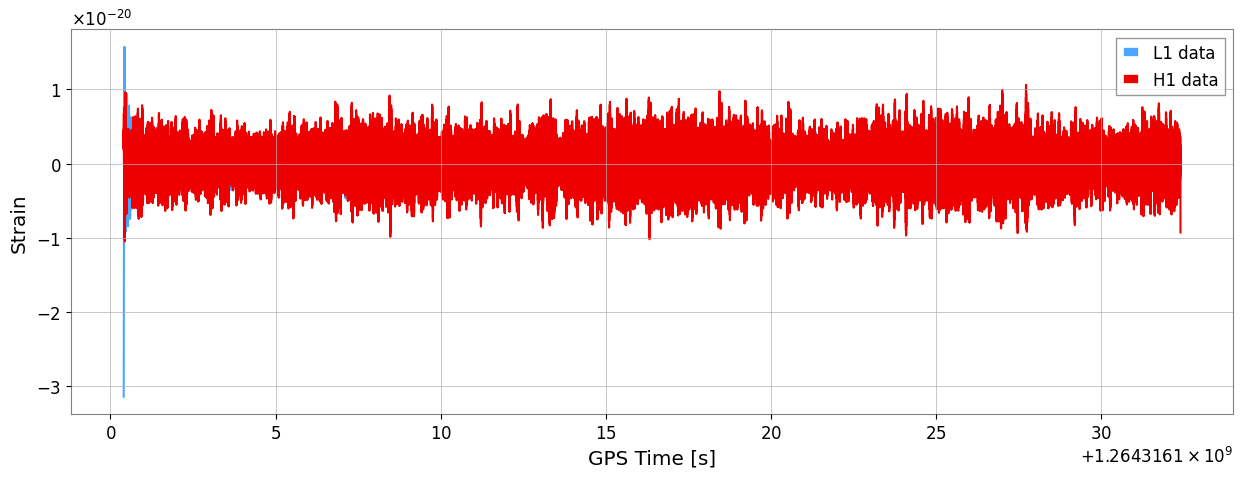

In [65]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford']
for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

The waveforms seem fairly similar, with the glitch in L1 as described in the paper being fairly obvious.

I'm not sure what to do about this...

The excess power from the glitch directly overlapping GW200129 in LIGO Livingston was subtracted before estimation of the signal’s source properties [1, 5] using the gwsubtract algorithm: https://arxiv.org/abs/1809.05348

In [66]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=4)

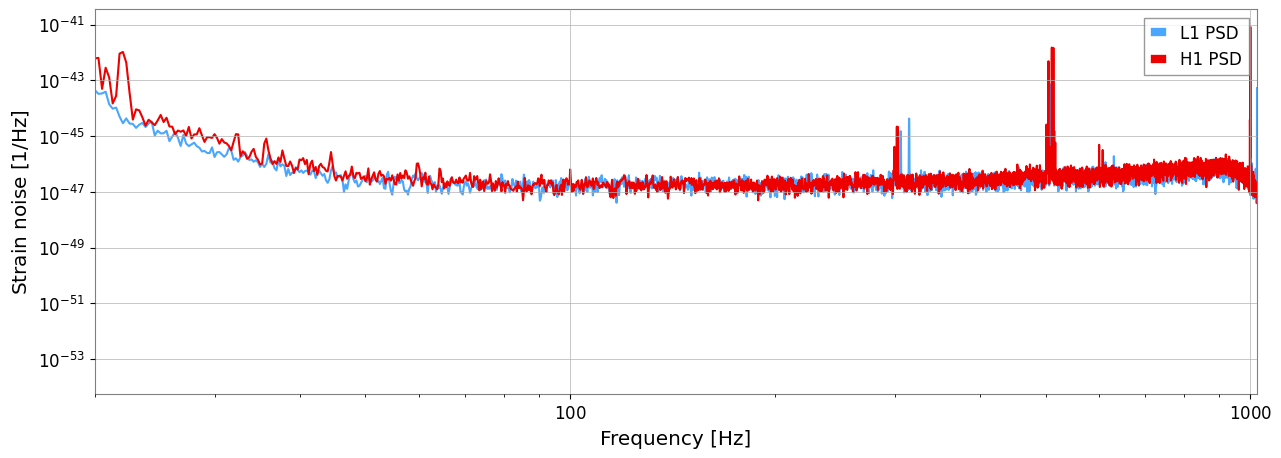

In [67]:

plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

In [68]:
from pycbc.waveform import get_td_waveform

Waveform systematics are expected to play a significant role in GW200129’s inference (e.g. Refs. [1, 14, 101]), which motivates utilizing NRSur7dq4 for all of our main text results.

It does not work :(

In [69]:
from pycbc.waveform import td_approximants, fd_approximants

print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'SEOBNRv4HM_PA', 'pSEOBNRv4HM_PA', 'IMRPhenomXAS_NRTidalv2', 'IMRPhenomXP_NRTidalv2', 'IMRPhenomXO4a', 'E

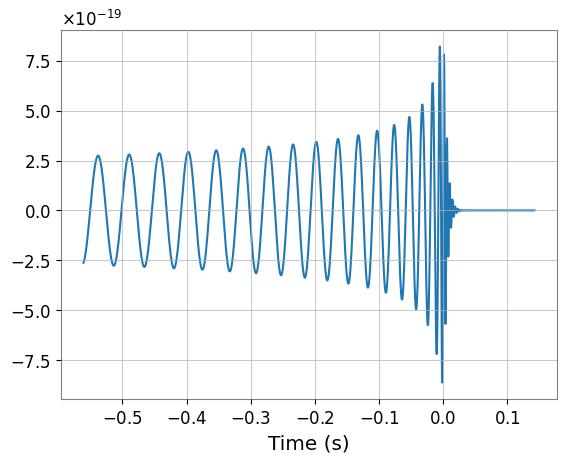

In [70]:
m1 = 34.5 * (1 + 0.18)
m2 = 29 * (1 + 0.18)
hp, hc = get_td_waveform(approximant='SEOBNRv4_opt',
                          mass1=m1,
                          mass2=m2,
                          delta_t=data['H1'].dt.value,
                          f_lower=20)
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

With two detectors we are potentially sensitive to more than a single polarization of gravitational
waves. We also have to account for the delay in the time of arrival of the signal based on where in
the sky the source may be located. This expands our parameters to be component mass (assuming
an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time,
merger phase, and polarization angle.
For a give set of parameters⃗ 𝜆 we’ll now have to generate the plus and cross polarizations of the GW
emission (taking into account the inclination of the binary, and scaling to the proper distance), then
combine these with each detector’s antenna pattern (which depend on the location of the binary
relative to the detector’s orientation) to determine the detector response. Finally, we have to shift
the time of arrival of the signal to be consistent with the delay time expected based on the RA and
dec of the binary.

In [71]:
from pycbc.detector import Detector

In [72]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

In [73]:
declination = 0
right_ascension = 5.5
polarization = 0.0 # uniform prior
fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination,polarization, time_centre)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.6744893702502468, fc=0.5331967726439342
H1: fp=-0.43843192801721637, fc=-0.5440881149926894


In [74]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

With the antenna beam pattern functions we can then compute the gravitational-wave signal as
seen by each detector:

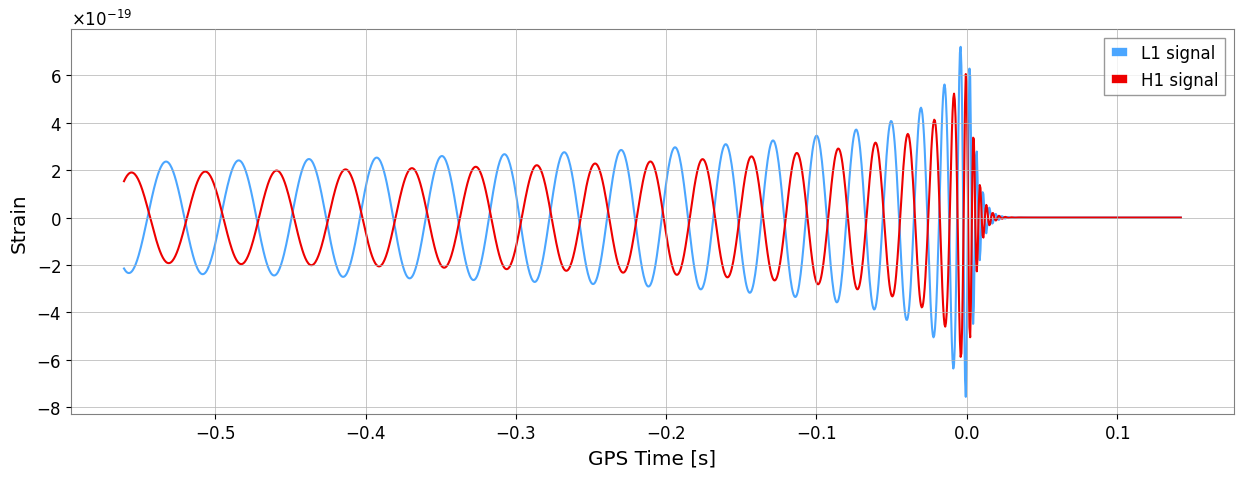

In [75]:
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
    plt.plot(TimeSeries.from_pycbc(ht[ifo]),label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend()

'The rate of glitches at frequencies similar to the signal is much lower; using data from 4 days around the event, the rate of glitches with frequency 60-120 Hz is only 0.06/hr.'

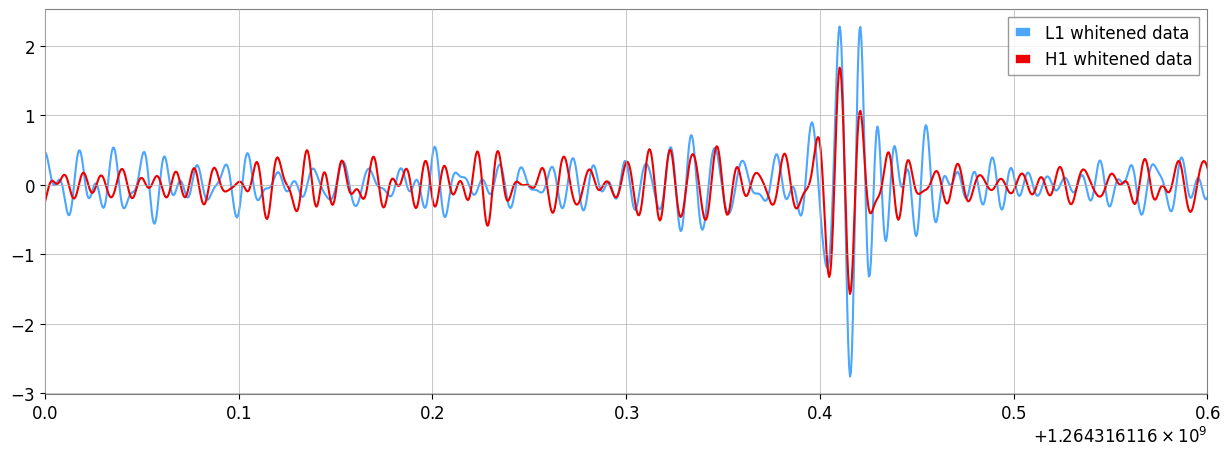

In [76]:
plt.figure(figsize=(15,5))
white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=4).bandpass(60,120)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
#plt.xlim(time_centre-4, time_centre+5.3)
plt.xlim(time_centre-0.4, time_centre+0.2)
plt.legend()

In [77]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination,time_centre)
print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_centre))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=5.5,dec=0, at time=1264316116.4,
the time delay between Hanford and geocenter is 0.013537617427967502 seconds


As in chapter 7, we’ll make a light-weight wrapper for get_td_waveform() that will take parameter
vector⃗ 𝜆 and generate a waveform for us with the same sampling rate and time window as our data.
However, this time we need to project the “plus” and “cross” polarisations onto the detector arms

In [78]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(time_centre-2,time_centre+2)

In [90]:
def gen_template(param,
    delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt
    duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
    start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
    f_lower=20.):
    m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=m1,
                            mass2=m2,
                            distance=distance,
                            inclination=inclination,
                            coa_phase=phase,
                            delta_t=delta_t,
                            f_lower=f_lower)
  # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    ht={}
    template={}
# compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination,polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension,declination, time)
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])
    return template

(1264316116.2, 1264316116.45)

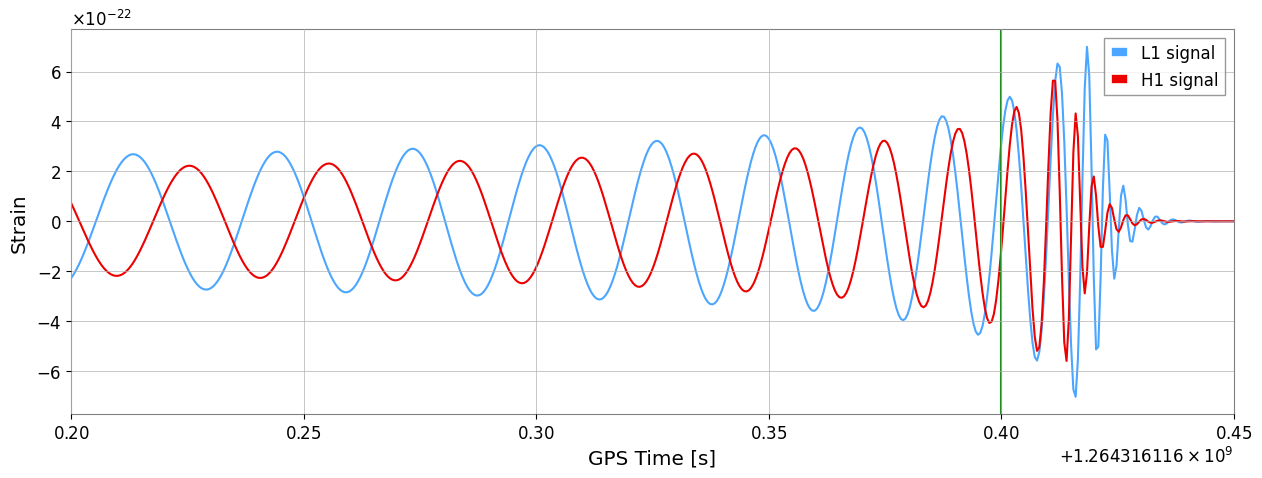

In [131]:
# Testing the gen_template() function:
param=[34.5,29,890,1264316116.4,0.0,5.5, 0, 0.001, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param
template=gen_template(param)
plt.figure(figsize=(15,5))
for ifo,colour in zip(ifos,colours):
  plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_centre,c='forestgreen')
plt.xlim([time_centre-0.2,time_centre+0.05])

With the network waveform generator now defined, we can define our likelihood function, which is
equivalent to the product of single-detector likelihood functions

To construct a likelihood function for the GW detector network (the two LIGO instruments in this
case), we will make the very reasonable assumption that noise is independent between detectors.
This means that our network likelihood fuction is just the product of single-detector likelihood
functions

In [107]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2
def loglikelihood(param, sf=sf, f_lower=20.0):
    hf_hp = {}

    logl=0.0

    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower)

    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)

        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() *hf_hp.df)
        h_dot_s = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() *sf_hp.df)

        logl += h_dot_s - h_dot_h/2
    return logl.value

-438.2018502306929


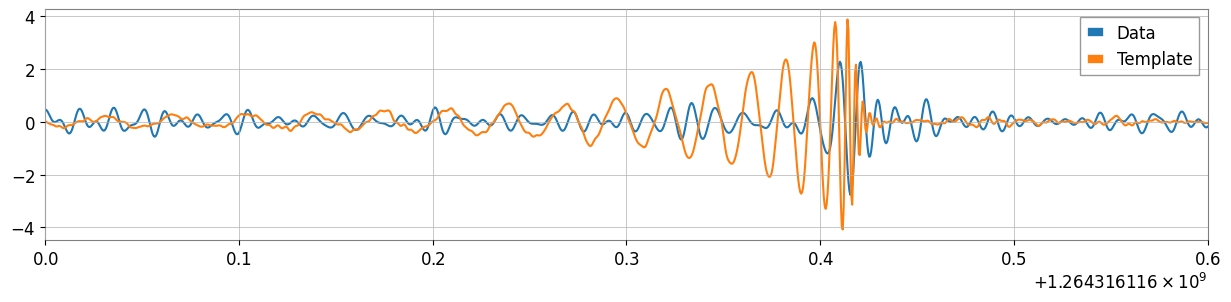

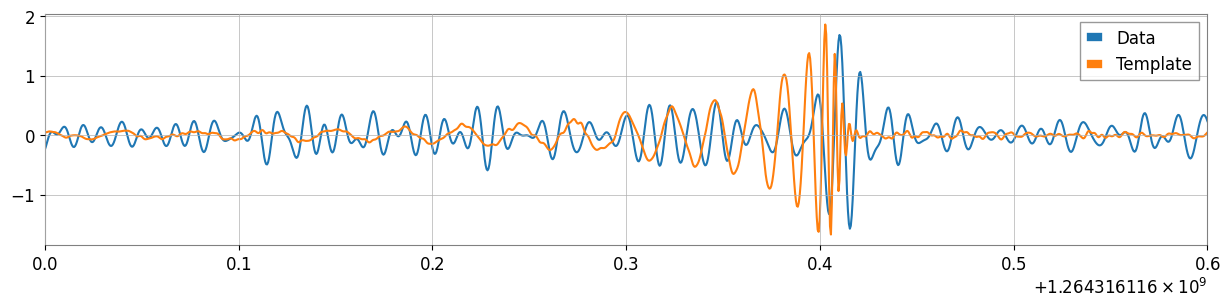

In [130]:
param0=[34.5,29,890,1264316116.4,0.0,0, 0.0, 0.001, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination,polarization = param

template0 = gen_template(param0)

for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], label="Data")
    plt.plot(white_template.times, white_template, label="Template")
    plt.xlim(time_centre-0.4, time_centre+0.2)
    plt.legend();

print(loglikelihood(param0))

Now let’s maximize the likelihood to find the best-fit signal. We’ll use the minimize() function
provided by scipy using the Powell method, since it’s pretty good at dealing with non-smooth
functions. We’ll also define a callback function to print likelihood values and plot the model as it
works.

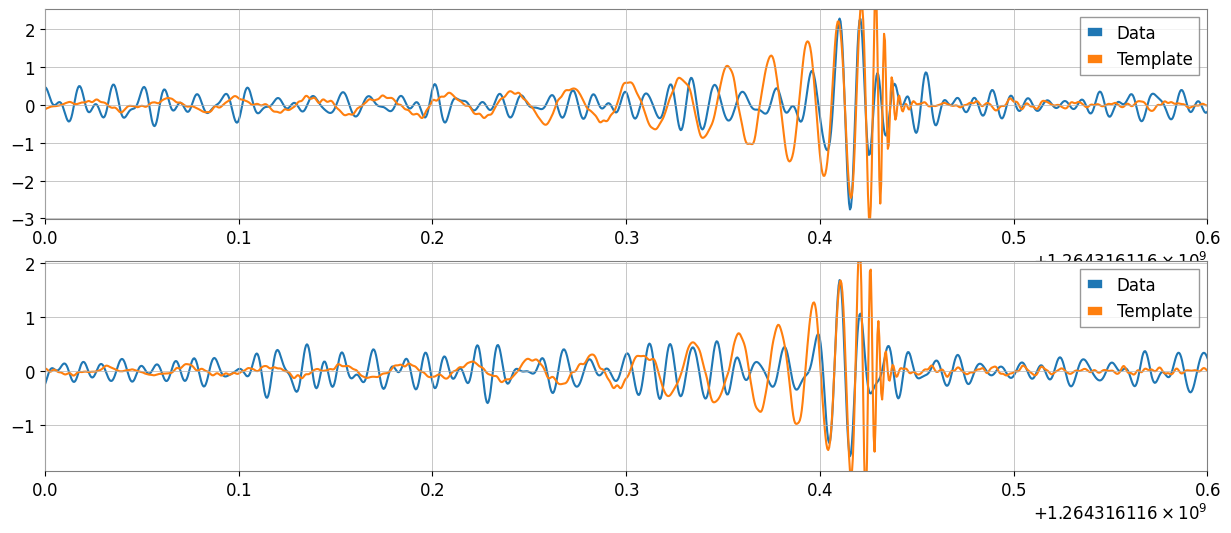

Steps	log(likelihood)
29	364.344


In [95]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))

    Neval += 1

res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()


Key Components of the Code:

    Plot Setup (matplotlib):

        You are creating a figure with two subplots using fig, axs = plt.subplots(2, 1, figsize=[15, 6]), where you likely plan to visualize the data and template.

        For each interferometer (IFO), you plot the white_data and the white_template (the template you are fitting), and later update the template as the optimization proceeds.

    callback function:

        The callback function is called each time the optimization procedure evaluates a new set of parameters (param_i).

        It generates a new template using the current parameters, whitens it, and updates the plot.

        The log-likelihood is computed for the current parameters, and the number of evaluations (Neval) is printed along with the log-likelihood.

        The plot is updated in real-time to show how the template fits the data.

    minimize function:

        The minimize function from scipy.optimize is used to find the optimal parameters by minimizing the negative log-likelihood.

        The optimization method used here is powell, which is a derivative-free method. It's appropriate for cases where you don't have a gradient of the function.

        The lambda function lambda param: -loglikelihood(param) is passed to minimize, which represents the negative log-likelihood function to be minimized.

        The callback function is passed to minimize, which updates the plot and prints information during each evaluation.

    clear_output(wait=True) and display(fig):

        These lines clear the previous plot and display the updated one, ensuring that the plot is refreshed after each optimization step.

        clear_output(wait=True) is used to avoid flickering, and display(fig) re-renders the figure.

    Plotting:

        The template is whitened using the whiten() function, which removes noise by dividing by the noise power spectral density (psd), and a high-pass filter is applied at 20 Hz.

        You then plot the data (white_data[ifo]) and the current template (white_template), updating them iteratively.

Potential Issues or Considerations:

    Imports: You haven't included the import statements for matplotlib.pyplot (import matplotlib.pyplot as plt) and other libraries that may be required for this code to work. Ensure you have the necessary imports.

    Function Definitions: The functions gen_template and loglikelihood are assumed to be defined elsewhere in your code. Make sure these functions are implemented correctly as per your specific use case (likely related to gravitational wave data fitting).

    ifo and ifos: These variables are assumed to be predefined lists or dictionaries containing interferometer names (e.g., LIGO detectors). Make sure they are properly initialized before running this code.

    param0: The initial guess for the parameters (param0) isn't defined in the code you posted. Ensure that this is set to an appropriate value for your fitting problem.

In [96]:
best_fit = res.x
best_fit_template = gen_template(best_fit) #best fit waveform found from optimisation of likelihood

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the Q-transform to produce a high-resolution time-frequency map of the data:

In [132]:
for i, ifo in enumerate(ifos):
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(time_centre - 1, time_centre + 1),
                                                     frange=(20, 512))

        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

Error in callback <function flush_figures at 0x7b7131bb4040> (for post_execute):


KeyboardInterrupt: 

As you can see above the generated waveform is successful as the residual between the data and generated waveform appears to be negligable.

Now let's make a model without any known priors (from the paper). We will assume a uniform prior since we don't know anything about the signal in this case.

In [138]:
import numpy as np

def logprior(param):
    # Unpack the parameters
    m1, m2, distance, time, phase, ra, dec, inclination, polarization = param

    # Check that the angles are within their valid ranges
    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2 * np.pi:
            return -np.inf  # Invalid angle

    # Check that distance is positive (uniform prior in log space)
    if distance <= 0:
        return -np.inf  # Invalid distance

    # Check that inclination and dec are within valid ranges
    if inclination < 0 or inclination > np.pi:
        return -np.inf  # Invalid inclination
    if dec < -np.pi / 2 or dec > np.pi / 2:
        return -np.inf  # Invalid declination

    # Uniform prior in volume: log(d) is uniform, so we do not penalize log(d)
    # No extra log scaling is needed for distance since it's uniform in log-space
    # So, logprior = 0 for valid parameters

    # For uniform priors on other parameters (phase, ra, inclination, etc.):
    # Uniform prior in the range [0, 2*pi] for ra, phase, polarization
    # Uniform prior for inclination between [0, pi] and declination between [-pi/2, pi/2]

    return 0  # Uniform prior for all valid parameters


With network likelihood and prior defined we can now take their product to get the posterior.

In [139]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [140]:
logposterior(param0)

np.float64(-438.2018502306929)



We can now maximize the posterior to determine the maximum a posteriori (MAP) parameters.

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

However, as the posterior is a density, the MAP does depend on the parametrisation we chose.


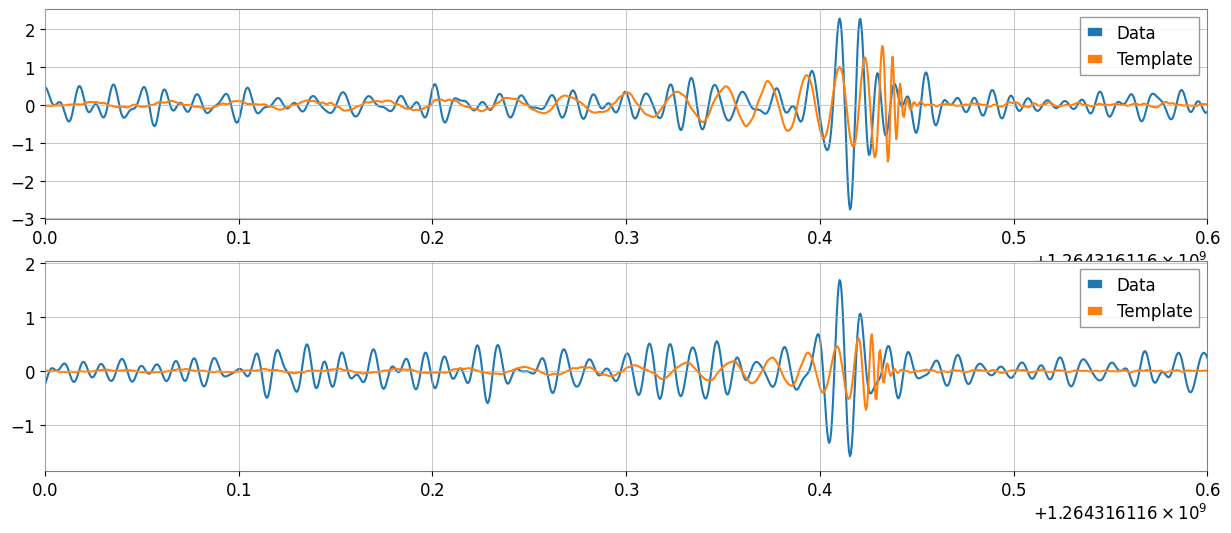

Steps	log(posterior)
16	74.312


In [141]:
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1

lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_centre-.4, time_centre+.2)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig

    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))

    Neval += 1

res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()